In [2]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
# Habitat-API
# All the boilerplate code in the habitat-sim to set sensor config 
# and agent config is abstracted out in the Habitat-API config system.
# Default config is at habitat/config/default.py. 
# You can override defaults by specifying them in a separate file and pass it to the get_config function
# or defrost the config object, override parameters and freeze the config

config = habitat.get_config(config_paths=\
                            '/media/shubodh/DATA/OneDrive/rrc_projects/2020/DeepGlobalRegistration-Navigation/'\
                            'habitat_all/habitat-api/configs/tasks/pointnav_mp3d.yaml')
config.defrost()
config.DATASET.DATA_PATH = '/media/shubodh/DATA/OneDrive/rrc_projects/2020/DeepGlobalRegistration-Navigation/'\
                            'habitat_all/habitat-api/data/datasets/pointnav/mp3d/v1/val/val.json.gz'
config.DATASET.SCENES_DIR = '/media/shubodh/DATA/OneDrive/rrc_projects/2020/DeepGlobalRegistration-Navigation/'\
                            'habitat_all/habitat-api/data/scene_datasets/'
config.freeze()

env = habitat.Env(config=config)

2020-07-23 23:43:45,144 Initializing dataset PointNav-v1


FileNotFoundError: [Errno 2] No such file or directory: '/media/shubodh/DATA/OneDrive/rrc_projects/2020/DeepGlobalRegistration-Navigation/habitat_all/habitat-api/data/datasets/pointnav/mp3d/v1/val/val.json.gz'

# Scene semantic annotations

In [3]:
def print_scene_recur(scene, limit_output=10):
    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return None

# Print semantic annotation information (id, category, bounding box details) 
# for the current scene in a hierarchical fashion
scene = env.sim.semantic_annotations()
print_scene_recur(scene, limit_output=15)
    
env.close() 
# Note: Since only one OpenGL is allowed per process, 
# you have to close the current env before instantiating a new one.

Level id:0, center:[11.0210495  3.996935   3.3452997], dims:[ 43.0625    8.19569 -30.1122 ]
Region id:0_0, category:rec/game, center:[16.61225    2.7802274 11.577564 ], dims:[10.364299   5.5838847 -4.14447  ]
Object id:0_0_0, category:ceiling, center:[16.5905   4.54488 11.269  ], dims:[9.984315  4.0917997 2.1377602]
Object id:0_0_1, category:wall, center:[16.5865     2.6818905 13.4147   ], dims:[9.69278   0.5280709 5.4398193]
Object id:0_0_2, category:wall, center:[21.6013     1.7400599 11.3493   ], dims:[3.5423203  0.41668844 3.921341  ]
Object id:0_0_3, category:door, center:[11.5374     1.2431393 10.386599 ], dims:[1.2573967  2.5311599  0.41445923]
Object id:0_0_4, category:door, center:[20.6332     1.2136002 13.5958   ], dims:[0.15834427 2.4860601  1.1674671 ]
Object id:0_0_5, category:wall, center:[16.5946    2.66614   9.331001], dims:[9.72554    0.23693037 5.3787804 ]
Object id:0_0_6, category:window, center:[16.5822    2.852209 13.596898], dims:[1.5934639  0.16375065 1.2588081 ]

# Take random actions and display sensor data

In [4]:
from PIL import Image
from habitat_sim.utils import d3_40_colors_rgb
import numpy as np

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

2019-06-06 16:11:46,319 initializing sim Sim-v0
2019-06-06 16:11:56,502 initializing task Nav-v0


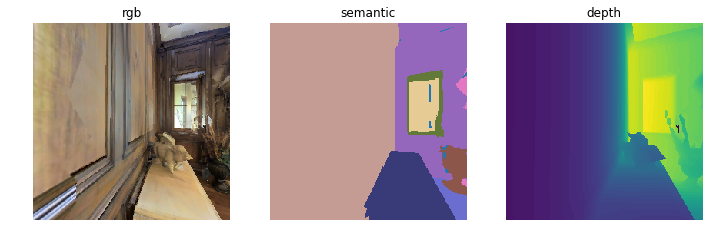

stop


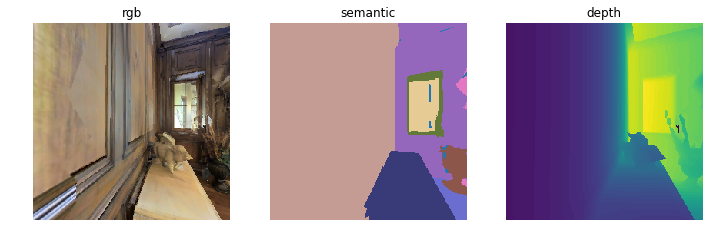

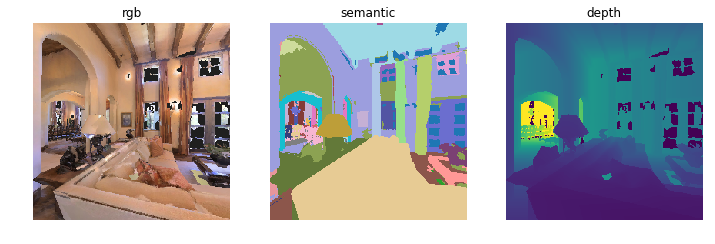

stop


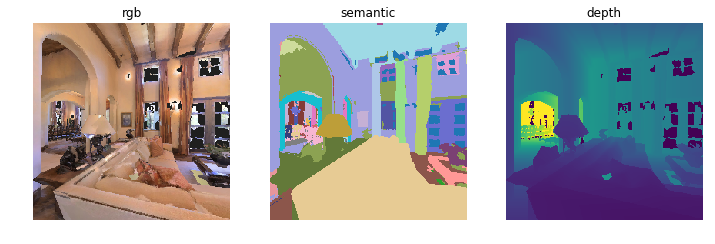

In [5]:
config = habitat.get_config(config_paths='../configs/tasks/pointnav_mp3d.yaml')
config.defrost()
config.DATASET.DATA_PATH = '../data/datasets/pointnav/mp3d/v1/val/val.json.gz'
config.DATASET.SCENES_DIR = '../data/scene_datasets/'
config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR', 'SEMANTIC_SENSOR']
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = 256
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = 256
config.SIMULATOR.TURN_ANGLE = 30
config.freeze()

env = habitat.Env(config=config)
env.episodes = random.sample(env.episodes, 2)

max_steps = 4

action_mapping = {
    0: 'stop',
    1: 'move_forward',
    2: 'turn left',
    3: 'turn right'
}

for i in range(len(env.episodes)):
    observations = env.reset()
    
    display_sample(observations['rgb'], observations['semantic'], np.squeeze(observations['depth']))
    
    count_steps = 0
    while count_steps < max_steps:
        action = random.choice(list(action_mapping.keys()))
        print(action_mapping[action])
        observations = env.step(action)
        display_sample(observations['rgb'], observations['semantic'], np.squeeze(observations['depth']))

        count_steps += 1
        if env.episode_over:
            break
        
env.close()